## Introduction

## Setup

In [1]:
### Load the required packages

import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

seed = 100
np.random.seed(seed)

In [2]:
### Load the dataset 
df = pd.read_csv('D:/Dataset/Side_project_Duplicate_question_detector/questions.csv', encoding='utf-8')

#### Overview of the dataset

In [3]:
print('Shape:')
print(df.shape)

print('\nSome examples:')
print(df.head())

print('\nInformation:')
print(df.info())

print('\nAny NAs?')
print(np.sum(df.isnull()))

Shape:
(404351, 6)

Some examples:
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  

Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 colu

There are only two NAs in this dataset, we can consider removing them since they account for very little part in this dataset.

In [4]:
### Target variable 

print('Distribution:')
print(df['is_duplicate'].value_counts())

print('\nDistribution in percentage:')
print(df['is_duplicate'].value_counts().apply(lambda x: x/len(df)*100))

Distribution:
0    255045
1    149306
Name: is_duplicate, dtype: int64

Distribution in percentage:
0    63.07515
1    36.92485
Name: is_duplicate, dtype: float64


Since the distribution of the target variable's classes are not so unbalanced, we can just move on

#### Remove the useless columns

In [5]:
### The columns qid1 and qid2 can be removed
df.drop(['qid1', 'qid2'], axis=1, inplace=True)

print(df.head()) # check the removal

   id                                          question1  \
0   0  What is the step by step guide to invest in sh...   
1   1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2  How can I increase the speed of my internet co...   
3   3  Why am I mentally very lonely? How can I solve...   
4   4  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


#### Remove the rows with NAs

In [6]:
df.dropna(how='any', inplace=True)

print(np.sum(df.isnull()))
print(df.info())

id              0
question1       0
question2       0
is_duplicate    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 404349 entries, 0 to 404350
Data columns (total 4 columns):
id              404349 non-null int64
question1       404349 non-null object
question2       404349 non-null object
is_duplicate    404349 non-null int64
dtypes: int64(2), object(2)
memory usage: 15.4+ MB
None


#### Since we aim to find ways to detect the duplicate articles, we have to first split out part of the dataset for testing later

In [7]:
### since the data would be very large if I use the traditional method for splitting (8:2), I would like to use only 20% as 
### as training set for exploring 

from sklearn.model_selection import train_test_split

df_tr, df_test = train_test_split(df, test_size=0.8, stratify=df['is_duplicate'], random_state=seed)

# check the split outcome 
print(df_tr['is_duplicate'].value_counts()/len(df_tr))
print(df_test['is_duplicate'].value_counts()/len(df_test))
print(df_tr.shape)
print(df_test.shape)

df_tr.index = range(len(df_tr))
df_test.index = range(len(df_test))

0    0.630748
1    0.369252
Name: is_duplicate, dtype: float64
0    0.63075
1    0.36925
Name: is_duplicate, dtype: float64
(80869, 4)
(323480, 4)


#### Transform the words to lowercase

In [8]:
df_tr['question1'] = df_tr['question1'].apply(lambda x: x.lower())
df_tr['question2'] = df_tr['question2'].apply(lambda x: x.lower())

print(df_tr.head()) # checking

       id                                          question1  \
0  159277          why do july and august have 31 days each?   
1  351344                       how do glands produce sweat?   
2    6412               what is indian army field artillery?   
3  173283                    does sandor clegane love sansa?   
4  240072  why do ideas come to me so easily when i am ta...   

                                           question2  is_duplicate  
0              why does july and august has 31 days?             1  
1  which glands produce sweat? how do they produc...             1  
2               what is the indian army's artillery?             1  
3                             who is sandor clegane?             0  
4  why do people have really good ideas in the sh...             1  


## EDA

#### The differences of length of each duplicate article

In [9]:
### Counstruct the tokenized object for each article 

print(df_tr['question1'][0])
print(df_tr['question2'][0])

from nltk.tokenize import word_tokenize

df_tr['q1_token'] = df_tr['question1'].apply(lambda x: word_tokenize(x))
df_tr['q2_token'] = df_tr['question2'].apply(lambda x: word_tokenize(x))

print(df_tr['q1_token'][0])
print(df_tr['q2_token'][0])

why do july and august have 31 days each?
why does july and august has 31 days?
['why', 'do', 'july', 'and', 'august', 'have', '31', 'days', 'each', '?']
['why', 'does', 'july', 'and', 'august', 'has', '31', 'days', '?']


In [10]:
### create the column for calculating differences of length

df_tr['len_diff'] = df_tr.ix[:, ['q1_token', 'q2_token']].apply(lambda x: np.abs(len(x[0]) - len(x[1])), axis=1)

print(df_tr['len_diff'].head()) # checking

0    1
1    5
2    1
3    1
4    4
Name: len_diff, dtype: int64


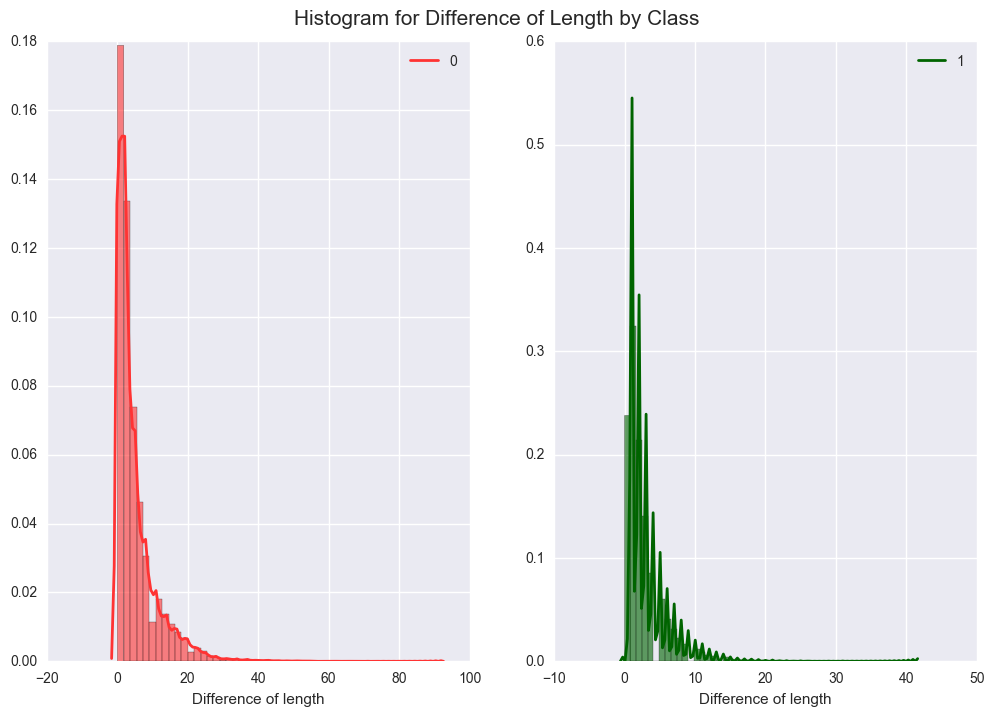

In [11]:
### Visualize the differences of length for each class

color_list = ['#FF3333', '#006400']


fig = plt.figure(figsize=[12, 8])
plt.suptitle('Histogram for Difference of Length by Class', fontsize=15, y=0.94)
for ind, col in enumerate(np.unique(df['is_duplicate']), start=1):
    axes = fig.add_subplot(1, 2, ind)
    sns.distplot(df_tr['len_diff'][df_tr['is_duplicate'].values == col].values,
                kde_kws={'alpha':1, 'label': str(col), 'lw':2}, 
                color = color_list[ind-1],
                hist_kws={'alpha':0.6})
    axes.set_xlabel('Difference of length')
    axes.legend()

From the two graphs above, I find that the differences in length of duplicate articles are less, which are larger than 50; however those in the non-duplicate group are more disperse and can be very large. That finding makes snese.

#### POS tagging each question 

In [12]:
from nltk import pos_tag as tag

import time
start_time = time.time()
df_tr['q1_pos'] = df_tr['q1_token'].apply(lambda x: tag(x))
df_tr['q2_pos'] = df_tr['q2_token'].apply(lambda x: tag(x))

print('execution time:', (time.time() - start_time))
print(df_tr.ix[:, ['q1_pos', 'q2_pos']].head()) # checking 

execution time: 529.6158382892609
                                              q1_pos  \
0  [(why, WRB), (do, VBP), (july, NN), (and, CC),...   
1  [(how, WRB), (do, VB), (glands, NNS), (produce...   
2  [(what, WP), (is, VBZ), (indian, JJ), (army, N...   
3  [(does, VBZ), (sandor, VB), (clegane, VB), (lo...   
4  [(why, WRB), (do, VBP), (ideas, NNS), (come, V...   

                                              q2_pos  
0  [(why, WRB), (does, VBZ), (july, NN), (and, CC...  
1  [(which, WDT), (glands, VBZ), (produce, VBP), ...  
2  [(what, WP), (is, VBZ), (the, DT), (indian, JJ...  
3  [(who, WP), (is, VBZ), (sandor, VBN), (clegane...  
4  [(why, WRB), (do, VBP), (people, NNS), (have, ...  


#### Remove the stopwords and punctuations and then lemmatize the remaining words given its pos

In [13]:
### load the stopwords
from nltk.corpus import stopwords
stop_words = list(set(stopwords.words('english')))
print(stop_words[:5])
print(len(stop_words))

### remove and lemmatiae the words 
import re

from nltk.stem import WordNetLemmatizer 
wnl = WordNetLemmatizer()

import time
start_time = time.time()

def pos_con(pos):
    pos_ind = pos[0].lower()
    if pos_ind == 'n':
        return 'n'
    elif pos_ind == 'j':
        return 'a'
    elif pos_ind == 'r':
        return 'r'
    elif pos_ind == 'v':
        return 'v'
    else:
        return 'n'

def filter_stop_punc_from_pos(pos_list):
    return [(wnl.lemmatize(pair[0], pos=pos_con(pair[1])), pair[1]) for pair in pos_list if not (re.match(r'\W', pair[0]) or (pair[0] in stop_words))]

df_tr['q1_pos_lem'] = df_tr['q1_pos'].apply(lambda x: filter_stop_punc_from_pos(x))
df_tr['q2_pos_lem'] = df_tr['q2_pos'].apply(lambda x: filter_stop_punc_from_pos(x))
print('execution time:', (time.time() - start_time))

print(df_tr.ix[:, ['q1_pos_lem', 'q2_pos_lem', 'is_duplicate']].head())

['if', 'then', 'after', 'has', 'while']
153
execution time: 18.263780117034912
                                          q1_pos_lem  \
0   [(july, NN), (august, NN), (31, CD), (day, NNS)]   
1         [(gland, NNS), (produce, VB), (sweat, NN)]   
2  [(indian, JJ), (army, NN), (field, NN), (artil...   
3  [(sandor, VB), (clegane, VB), (love, VB), (san...   
4  [(idea, NNS), (come, VB), (easily, RB), (take,...   

                                          q2_pos_lem  is_duplicate  
0   [(july, NN), (august, NN), (31, CD), (day, NNS)]             1  
1  [(glands, VBZ), (produce, VBP), (sweat, NN), (...             1  
2        [(indian, JJ), (army, NN), (artillery, NN)]             1  
3                     [(sandor, VBN), (clegane, NN)]             0  
4  [(people, NNS), (really, RB), (good, JJ), (ide...             1  


#### calculate the cosine similarity with the use of wordnet similarity

In [14]:
### remove the words with numbers
start_time = time.time()
df_tr['q1_pos_lem_con'] = df_tr['q1_pos_lem'].apply(lambda x: ' '.join([pair[0]+pos_con(pair[1]) for pair in x if not re.match(r'.*\d+.*', pair[0])]))
df_tr['q2_pos_lem_con'] = df_tr['q2_pos_lem'].apply(lambda x: ' '.join([pair[0]+pos_con(pair[1]) for pair in x if not re.match(r'.*\d+.*', pair[0])]))
print('execution time:', (time.time() - start_time))

execution time: 2.5769386291503906


In [29]:
### Calculate the modified-form cosine similarity

def cal_cos_sim_wordnet(df):

    from nltk.corpus import wordnet as wn
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    threshold = 0.8
    
    cos_sim = []
    
    for ind in range(len(df)):
        
        try:
            corpus = [df['q1_pos_lem_con'][ind], df['q2_pos_lem_con'][ind]]
            vectorizer = TfidfVectorizer()
            tf_mat = vectorizer.fit_transform(corpus).todense()
            vec_1 = np.array(tf_mat[0])
            vec_2 = np.array(tf_mat[1])
            name_vec = sorted(vectorizer.vocabulary_, key=vectorizer.vocabulary_.get)          

            def word_sim(name_vec):
                mat = np.zeros([len(name_vec), len(name_vec)])

                for i in range(len(name_vec)):
                    for j in range(len(name_vec)):
                        if i == j:
                            mat[i, j] = 1
                        else:
                            try:
                                score = wn.synset(name_vec[i][:-1]+'.'+name_vec[i][-1]+'.01').wup_similarity(wn.synset(name_vec[j][:-1]+'.'+name_vec[j][-1]+'.01'))
                                if score == None:
                                    mat[i, j] = 0
                                elif score >= threshold:
                                    mat[i, j] = score
                                else: 
                                    mat[i, j] = 0
                            except:
                                mat[i, j] = 0
                mat[np.isnan(mat)] = 0
                return mat 

            cos_sim.append(float(np.dot(vec_1, word_sim(name_vec)).dot(vec_2.T)/(np.linalg.norm(vec_1)*np.linalg.norm(vec_2))))
        except:
            cos_sim.append(0)

    return cos_sim

start_time = time.time()    
df_tr['cos_sim'] = cal_cos_sim_wordnet(df_tr)
print('execution time:', (time.time() - start_time))

execution time: 582.9058992862701


In [30]:
df_tr['cos_sim'][np.isnan(df_tr['cos_sim'].values)] = 0

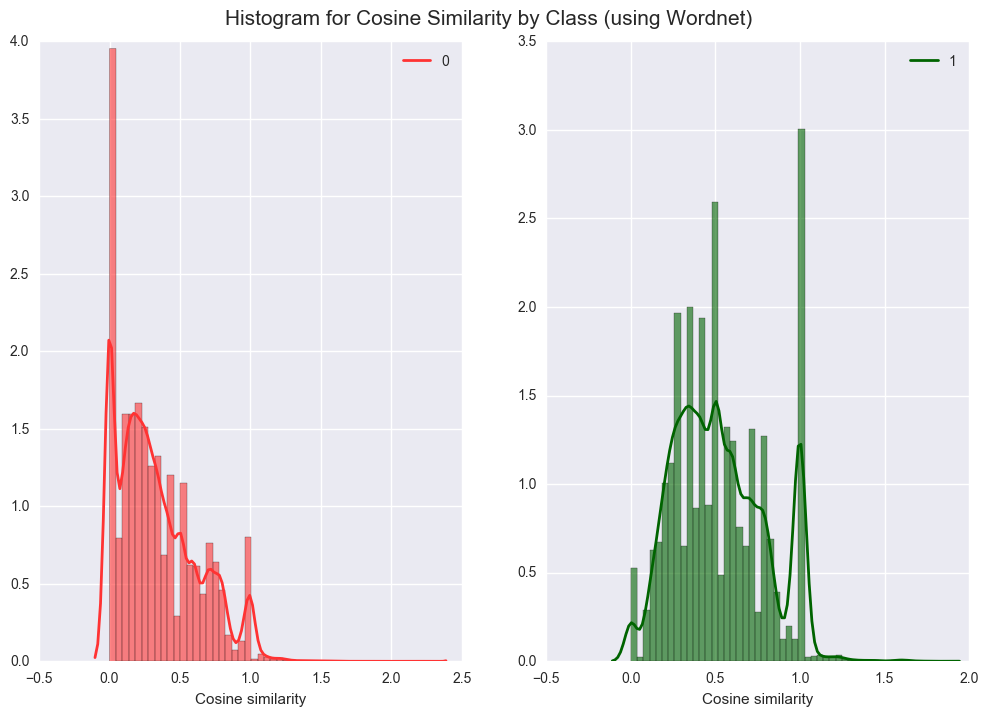

In [40]:
color_list = ['#FF3333', '#006400']

fig = plt.figure(figsize=[12, 8])
plt.suptitle('Histogram for Cosine Similarity by Class (using Wordnet)', fontsize=15, y=0.94)
for ind, col in enumerate(np.unique(df['is_duplicate']), start=1):
    axes = fig.add_subplot(1, 2, ind)
    sns.distplot(df_tr['cos_sim'][df_tr['is_duplicate'].values == col].values,
                kde_kws={'alpha':1, 'label': str(col), 'lw':2},
                bins=50,
                color = color_list[ind-1],
                hist_kws={'alpha':0.6})
    axes.set_xlabel('Cosine similarity')
    axes.legend()

#### calculate the cosine similarity 

In [21]:
### Calculate the original cosine similarity

def cal_cos_sim_original(df):

    from nltk.corpus import wordnet as wn
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    cos_sim = []
    
    for i in range(len(df)):
        
        try:
            corpus = [df['q1_pos_lem_con'][i], df['q2_pos_lem_con'][i]]
            vectorizer = TfidfVectorizer()
            tf_mat = vectorizer.fit_transform(corpus).todense()
            vec_1 = np.array(tf_mat[0])
            vec_2 = np.array(tf_mat[1])

            cos_sim.append(float(np.dot(vec_1, vec_2.T)/(np.linalg.norm(vec_1)*np.linalg.norm(vec_2))))
        except:
            cos_sim.append(0)

    return cos_sim

start_time = time.time()    
df_tr['cos_sim_original'] = cal_cos_sim_original(df_tr)
print('execution time:', (time.time() - start_time))

execution time: 141.85041666030884


In [22]:
df_tr['cos_sim_original'][np.isnan(df_tr['cos_sim_original'].values)] = 0

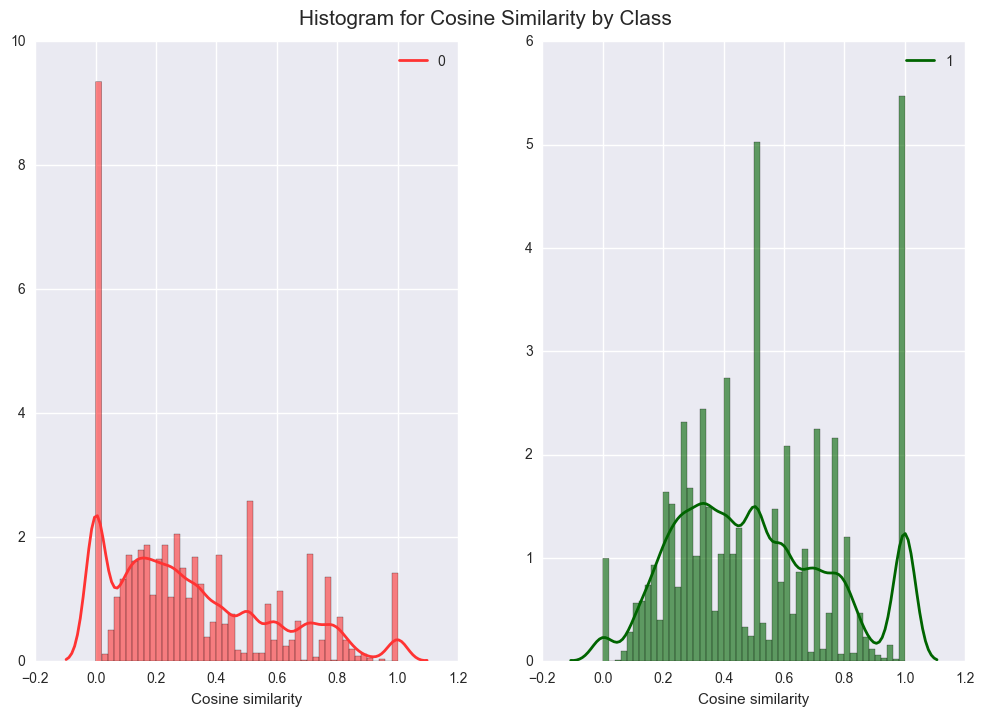

In [23]:
color_list = ['#FF3333', '#006400']

fig = plt.figure(figsize=[12, 8])
plt.suptitle('Histogram for Cosine Similarity by Class', fontsize=15, y=0.94)
for ind, col in enumerate(np.unique(df['is_duplicate']), start=1):
    axes = fig.add_subplot(1, 2, ind)
    sns.distplot(df_tr['cos_sim_original'][df_tr['is_duplicate'].values == col].values,
                kde_kws={'alpha':1, 'label': str(col), 'lw':2},
                bins=50,
                color = color_list[ind-1],
                hist_kws={'alpha':0.6})
    axes.set_xlabel('Cosine similarity')
    axes.legend()

#### Calculate Jaccard similarity

In [42]:
start_time = time.time()
df_tr['q1_pos_lem_con_list'] = df_tr['q1_pos_lem'].apply(lambda x: [pair[0]+pos_con(pair[1]) for pair in x if not re.match(r'.*\d+.*', pair[0])])
df_tr['q2_pos_lem_con_list'] = df_tr['q2_pos_lem'].apply(lambda x: [pair[0]+pos_con(pair[1]) for pair in x if not re.match(r'.*\d+.*', pair[0])])
print('execution time:', (time.time() - start_time))

execution time: 2.862138509750366


In [54]:
def jaccard_sim(df):
    
    jac_sim = []
    
    for i in range(len(df)):
        try:
            vec_1 = np.unique(df['q1_pos_lem_con_list'][i])
            vec_2 = np.unique(df['q2_pos_lem_con_list'][i])

            jac_sim.append(len(np.intersect1d(vec_1, vec_2))/len(np.union1d(vec_1, vec_2)))
        except:
            jac_sim.append(0)    
    return jac_sim

start_time = time.time()  
df_tr['jac_sim'] = jaccard_sim(df_tr)
print('execution time:', (time.time() - start_time))  

execution time: 10.420229434967041


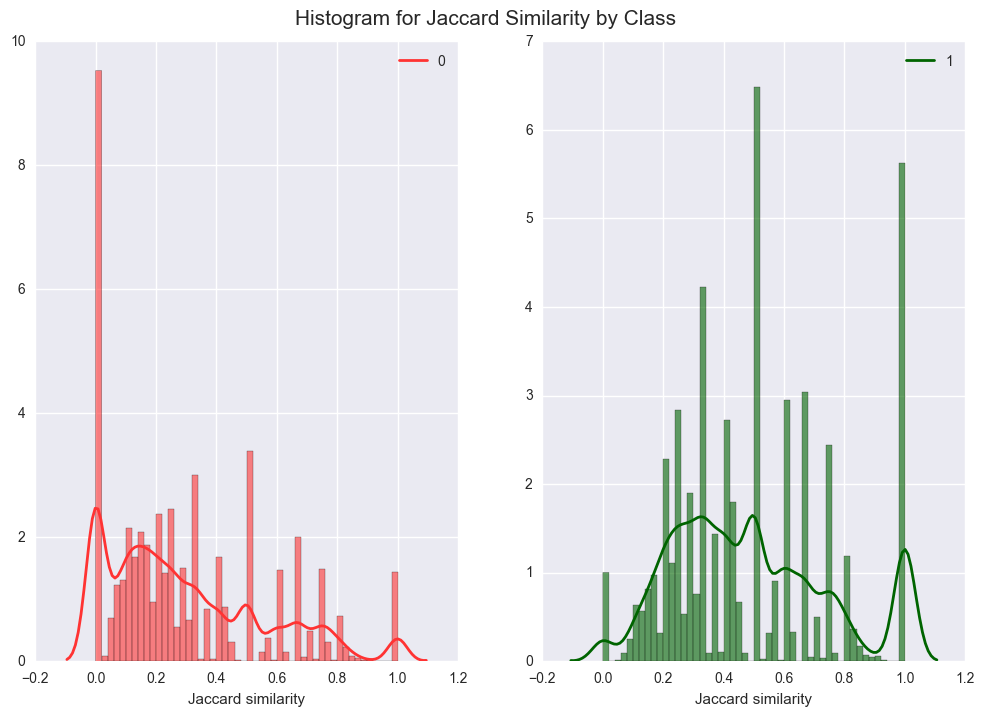

In [58]:
color_list = ['#FF3333', '#006400']

fig = plt.figure(figsize=[12, 8])
plt.suptitle('Histogram for Jaccard Similarity by Class', fontsize=15, y=0.94)
for ind, col in enumerate(np.unique(df['is_duplicate']), start=1):
    axes = fig.add_subplot(1, 2, ind)
    sns.distplot(df_tr['jac_sim'][df_tr['is_duplicate'].values == col].values,
                kde_kws={'alpha':1, 'label': str(col), 'lw':2},
                bins=50,
                color = color_list[ind-1],
                hist_kws={'alpha':0.6})
    axes.set_xlabel('Jaccard similarity')
    axes.legend()

#### Use Doc2Vec

In [105]:
### label the sentences
from gensim.models.doc2vec import LabeledSentence

question_labels = []

n = -1

for i in range(len(df_tr)):
    if not(len(df_tr['q1_pos_lem_con_list'][i]) == 0 or len(df_tr['q2_pos_lem_con_list'][i]) == 0):
        n+=1
        question_labels.append(LabeledSentence(df_tr['q1_pos_lem_con_list'][i], [str(n)]))
        n+=1
        question_labels.append(LabeledSentence(df_tr['q2_pos_lem_con_list'][i], [str(n)]))
    else:
        None
    if i % 10000 == 0:
        print('%.2f%% completed' %(i/len(df_tr)*100))

0.00% completed
12.37% completed
24.73% completed
37.10% completed
49.46% completed
61.83% completed
74.19% completed
86.56% completed
98.93% completed


In [106]:
### Calculate the distribution of lengths of each processed question

length_list = [len(pair[0]) for pair in question_labels]
length_list = np.array(length_list)
print(length_list[:5])

[3 3 3 5 4]


In [107]:
### Check the lengths for further parameters setting 

print(pd.Series(length_list).describe())
np.percentile(length_list, q=[90])

count    161592.000000
mean          5.354659
std           2.955565
min           1.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          54.000000
dtype: float64


array([ 9.])

In [127]:
### Doc2Vec model
from gensim.models import Doc2Vec
model = Doc2Vec(dm = 1, min_count=1, window=2, size=200, sample=1e-4, negative=10, workers=8)
model.build_vocab(question_labels)

In [128]:
### Train the model
start_time = time.time()  
for epoch in range(10):
    model.train(question_labels)
    print("Epoch #{} is complete.".format(epoch+1))
print('execution time:', (time.time() - start_time)) 

Epoch #1 is complete.
Epoch #2 is complete.
Epoch #3 is complete.
Epoch #4 is complete.
Epoch #5 is complete.
Epoch #6 is complete.
Epoch #7 is complete.
Epoch #8 is complete.
Epoch #9 is complete.
Epoch #10 is complete.
execution time: 432.0096368789673


In [129]:
model.n_similarity(df_tr['q1_pos_lem_con_list'][1100], df_tr['q1_pos_lem_con_list'][1100])
### Calculate the similarity

def doc2vec_sim(df):

    d2v_sim = []
    
    for i in range(len(df)):
        try:
            # n_similarity computes the cosine similarity in Doc2Vec
            score = model.n_similarity(df_tr['q1_pos_lem_con_list'][i], df_tr['q1_pos_lem_con_list'][i])
            d2v_sim.append(score)
        except:
            d2v_sim.append(0)
    return d2v_sim

start_time = time.time()  
df_tr['d2v_sim'] = doc2vec_sim(df_tr)
print('execution time:', (time.time() - start_time))  

execution time: 12.327433824539185


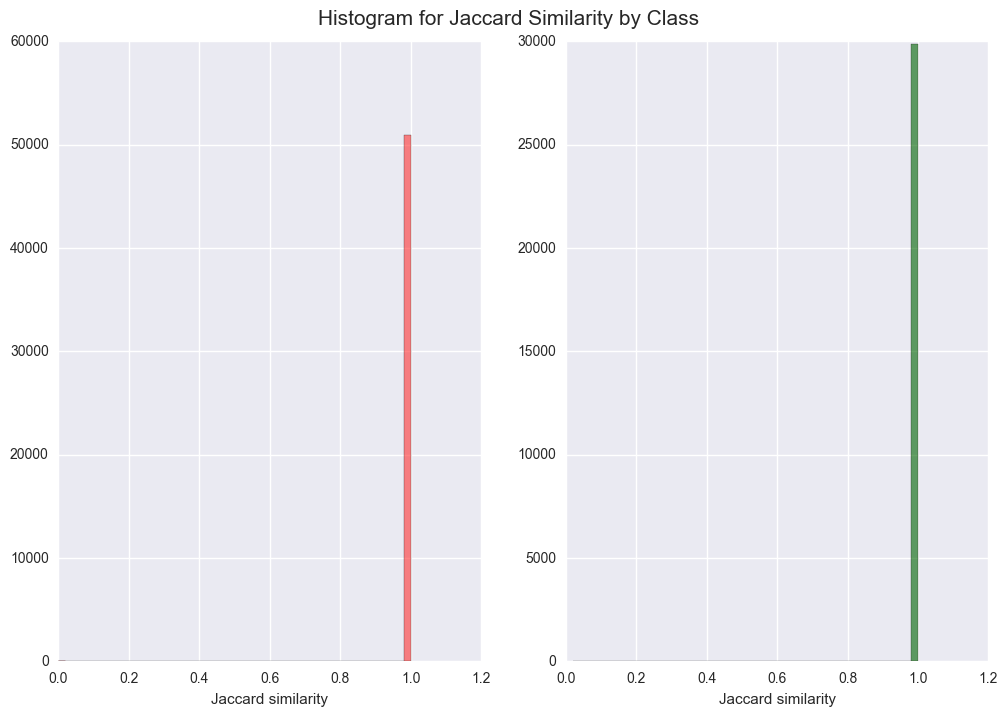

In [130]:
color_list = ['#FF3333', '#006400']

fig = plt.figure(figsize=[12, 8])
plt.suptitle('Histogram for Jaccard Similarity by Class', fontsize=15, y=0.94)
for ind, col in enumerate(np.unique(df['is_duplicate']), start=1):
    axes = fig.add_subplot(1, 2, ind)
    sns.distplot(df_tr['d2v_sim'][df_tr['is_duplicate'].values == col].values,
                kde_kws={'alpha':1, 'label': str(col), 'lw':2},
                bins=50,
                color = color_list[ind-1],
                kde=False,
                hist_kws={'alpha':0.6})
    axes.set_xlabel('Jaccard similarity')
    axes.legend()

#### Calculate K-Shingles 

In [134]:
### define the function 
def kshingles(vec, k):
    return [vec[i:i+k] for i in range(len(vec)-k+1)]

In [136]:
start_time = time.time()
df_tr['q1_pos_lem_con_2shingles'] = df_tr['q1_pos_lem_con_list'].apply(lambda x: kshingles(x, 2))
df_tr['q2_pos_lem_con_2shingles'] = df_tr['q2_pos_lem_con_list'].apply(lambda x: kshingles(x, 2))
print('execution time:', (time.time() - start_time))

execution time: 1.7319531440734863


In [138]:
def jaccard_sim_2shingles(df):
    
    jac_sim = []
    
    for i in range(len(df)):
        try:
            vec_1 = np.unique(df['q1_pos_lem_con_2shingles'][i])
            vec_2 = np.unique(df['q2_pos_lem_con_2shingles'][i])

            jac_sim.append(len(np.intersect1d(vec_1, vec_2))/len(np.union1d(vec_1, vec_2)))
        except:
            jac_sim.append(0)    
    return jac_sim

start_time = time.time()  
df_tr['jac_sim_2shingles'] = jaccard_sim_2shingles(df_tr)
print('execution time:', (time.time() - start_time)) 

execution time: 11.93026614189148


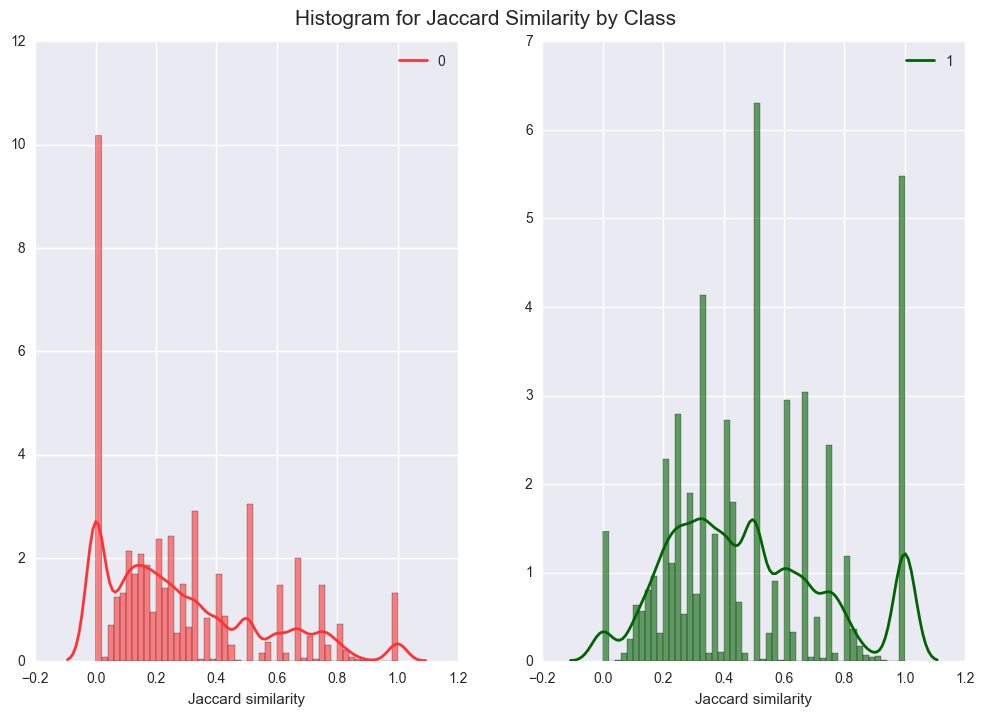

In [140]:
color_list = ['#FF3333', '#006400']

fig = plt.figure(figsize=[12, 8])
plt.suptitle('Histogram for Jaccard Similarity by Class', fontsize=15, y=0.94)
for ind, col in enumerate(np.unique(df['is_duplicate']), start=1):
    axes = fig.add_subplot(1, 2, ind)
    sns.distplot(df_tr['jac_sim_2shingles'][df_tr['is_duplicate'].values == col].values,
                kde_kws={'alpha':1, 'label': str(col), 'lw':2},
                bins=50,
                color = color_list[ind-1],
                hist_kws={'alpha':0.6})
    axes.set_xlabel('Jaccard similarity')
    axes.legend()

## Modeling

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

X = df_tr.ix[:, ['cos_sim', 'cos_sim_original', 'jac_sim', 'jac_sim_2shingles']].values
y = df_tr['is_duplicate'].values

np.random.seed(seed)
model = LogisticRegression()
score = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print(score)

np.random.seed(seed)
model = RandomForestClassifier()
score = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print(score)

np.random.seed(seed)
model = XGBClassifier()
score = cross_val_score(model, X, y, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
print(score)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


[ 0.64513138  0.64974651  0.65432175  0.64193409  0.65294009]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


[ 0.68049459  0.6743539   0.68573018  0.67915662  0.6765597 ]
[ 0.68068006  0.67701249  0.68338073  0.68008409  0.67643604]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished


In [ ]:
[ 0.64463679  0.64881909  0.65407444  0.64193409  0.65182712]
[ 0.67826893  0.67373563  0.68338073  0.67470475  0.67668336]
[ 0.6774034   0.67528132  0.67942377  0.67495208  0.67111853]

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = df_tr.ix[:, ['cos_sim', 'cos_sim_original', 'jac_sim', 'jac_sim_2shingles']].values
y = df_tr['is_duplicate'].values

np.random.seed(seed)
model = LogisticRegression()
score = cross_val_score(model, X, y, cv=5, scoring='precision', n_jobs=-1, verbose=1)
print(score)

np.random.seed(seed)
model = RandomForestClassifier(n_estimators=100)
score = cross_val_score(model, X, y, cv=5, scoring='precision', n_jobs=-1, verbose=1)
print(score)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


[ 0.53114141  0.54185983  0.55114094  0.52492426  0.54857916]
[ 0.57482054  0.57117988  0.57882136  0.57440812  0.57291861]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.5s finished


In [ ]:
[ 0.52329149  0.53939394  0.54825518  0.52002288  0.5342312 ]
[ 0.56697009  0.56123686  0.57284705  0.56361829  0.55632184]

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = df_tr.ix[:, ['cos_sim', 'cos_sim_original', 'jac_sim', 'jac_sim_2shingles']].values
y = df_tr['is_duplicate'].values

np.random.seed(seed)
model = LogisticRegression()
score = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1, verbose=1)
print(score)

np.random.seed(seed)
model = RandomForestClassifier(n_estimators=100)
score = cross_val_score(model, X, y, cv=5, scoring='f1', n_jobs=-1, verbose=1)
print(score)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


[ 0.40910027  0.41228343  0.42342993  0.39695928  0.41936485]
[ 0.54700255  0.53330946  0.54903339  0.53968254  0.53616338]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished
